# Add batch effects

Say we are interested in identifying genes that differentiate between disease vs normal states.  However our dataset includes samples from different tissues or time points and there are variations in gene expression that are due to these other conditions and do not have to do with disease state.  These non-relevant variations in the data are called *batch effects*.  

We want to model these batch effects.  To do this we will:
1. Partition our simulated data into n batches
2. For each partition we will randomly shift the expression data.  We randomly generate a binary vector of length=number of genes (*offset vector*).  This vector will serve as the direction that we will shift to.  Then we also have a random scalar that will tell us how big of a step to take in our random direction (*stretch factor*).  We shift our partitioned data by: batch effect partition = partitioned data + stretch factor * offset vector
3. Repeat this for each partition
4. Append all batch effect partitions together


In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import umap

from ggplot import *
from sklearn.decomposition import PCA
from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [2]:
# Parameters
analysis_name = 'treatment'
num_simulations = 10
num_batches = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]

In [3]:
# Create directories
new_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "batch_simulated")

analysis_dir = os.path.join(new_dir, analysis_name)

if os.path.exists(analysis_dir):
    print('directory already exists: {}'.format(analysis_dir))
else:
    print('creating new directory: {}'.format(analysis_dir))
os.makedirs(analysis_dir, exist_ok=True)

directory already exists: /home/alexandra/Documents/Repos/Batch_effects_simulation/data/batch_simulated/treatment


In [4]:
# Load arguments
simulated_data_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "simulated",
    analysis_name,
    "simulated_data.txt")

In [5]:
# Read in metadata
simulated_data = pd.read_table(simulated_data_file, header=0, index_col=0, sep='\t')
simulated_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.628964,0.646908,0.480636,0.620393,0.422232,0.382635,0.402595,0.553750,0.520048,0.258603,...,0.359013,0.551646,0.611666,0.598276,0.628137,0.287001,0.529758,0.509939,0.633529,0.619872
1,0.678382,0.703188,0.527437,0.704238,0.430164,0.368354,0.352613,0.620724,0.549424,0.245592,...,0.290579,0.558925,0.627152,0.640999,0.608726,0.258124,0.593195,0.531552,0.668047,0.636569
2,0.641916,0.678264,0.463933,0.648859,0.409863,0.350796,0.389504,0.537631,0.512888,0.260378,...,0.330708,0.536779,0.598897,0.578997,0.599701,0.278488,0.516988,0.463365,0.624215,0.609901
3,0.594767,0.636643,0.416453,0.628747,0.416945,0.351811,0.360039,0.535116,0.497940,0.247161,...,0.321353,0.538036,0.635792,0.567058,0.585936,0.300398,0.530513,0.518424,0.635868,0.630736
4,0.640293,0.671701,0.469927,0.638791,0.417401,0.379394,0.344619,0.545680,0.521381,0.243920,...,0.351509,0.556058,0.630285,0.597943,0.630032,0.268888,0.538156,0.488934,0.651016,0.637002
5,0.570821,0.614700,0.416570,0.604431,0.416258,0.360512,0.358066,0.490945,0.439193,0.246253,...,0.367628,0.549973,0.604247,0.556710,0.583859,0.290600,0.514078,0.480668,0.605616,0.590260
6,0.645699,0.667780,0.458968,0.638642,0.397041,0.350572,0.376161,0.553894,0.503935,0.227837,...,0.304722,0.536894,0.607844,0.574936,0.595981,0.249020,0.486854,0.504910,0.648401,0.630152
7,0.596162,0.595165,0.455493,0.570292,0.422777,0.393874,0.380671,0.522127,0.467170,0.259574,...,0.374777,0.547841,0.605506,0.556260,0.571638,0.298073,0.522282,0.468431,0.593866,0.586248
8,0.634383,0.675939,0.478415,0.639174,0.427510,0.360819,0.372903,0.576739,0.521625,0.250696,...,0.331871,0.548516,0.630932,0.604443,0.607249,0.264769,0.530942,0.530085,0.666258,0.651207
9,0.631214,0.669070,0.428945,0.636960,0.437791,0.365943,0.337859,0.505510,0.479455,0.242183,...,0.329414,0.559434,0.628833,0.567533,0.591657,0.289760,0.493780,0.462707,0.642027,0.619266


In [6]:
# Add batch effects
# ADD MULTIPLE SIMULATION RUNS
num_simulated_samples = simulated_data.shape[0]
num_genes = simulated_data.shape[1]
subset_genes_to_change = np.random.RandomState(randomState).choice([0, 1], size=(num_genes), p=[1./3, 2./3])
    
for i in num_batches:
    print(i)
    
    batch_file = os.path.join(
            os.path.dirname(os.getcwd()),
            "data",
            "batch_simulated",
            analysis_name,
            "Batch_"+str(i)+".txt")
    
    num_samples_per_batch = int(num_simulated_samples/i)
    
    if i == 1:        
        simulated_data.to_csv(batch_file, sep='\t')
        
    else:  
        batch_data_df = pd.DataFrame()
        for j in range(i):
            
            # CLEAN UP
            #print('batch number: {}'.format(j))
            #if j == 0:
                # Randomly select samples
            #   batch_df = new_data_decoded_df.sample(n=num_samples_per_batch, frac=None, replace=False)
            #   batch_data_df = batch_data_df.append(batch_df)    
            #else:
            
            stretch_factor = np.random.uniform(0,1)
            
            # Randomly select samples
            batch_df = simulated_data.sample(n=num_samples_per_batch, frac=None, replace=False)
            batch_df.columns = batch_df.columns.astype(str)

            # Add batch effect
            subset_genes_to_change_tile = pd.DataFrame(
                pd.np.tile(
                    subset_genes_to_change,
                    (num_samples_per_batch, 1)),
                index=batch_df.index)

            offset_vector = pd.DataFrame(subset_genes_to_change_tile*stretch_factor)
            offset_vector.columns = offset_vector.columns.astype(str)
            batch_df = batch_df + offset_vector

            # if any exceed 1 then set to 1 since gene expression is normalized
            batch_df[batch_df>=1.0] = 1.0


            # Append batched together
            batch_data_df = batch_data_df.append(batch_df)

            # Select a new direction (i.e. a new subset of genes to change)
            np.random.shuffle(subset_genes_to_change)
            
        # Save
        batch_data_df.to_csv(batch_file, sep='\t')

1
2
3
4
5
6
7
8
9
10
15
20
25
30
35
40
45
50


## Plot batch data using UMAP

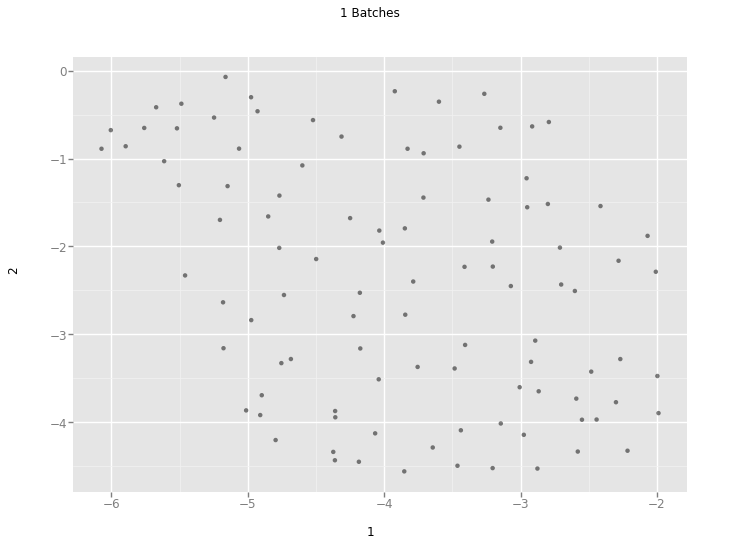

<ggplot: (-9223363262513734442)>


/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


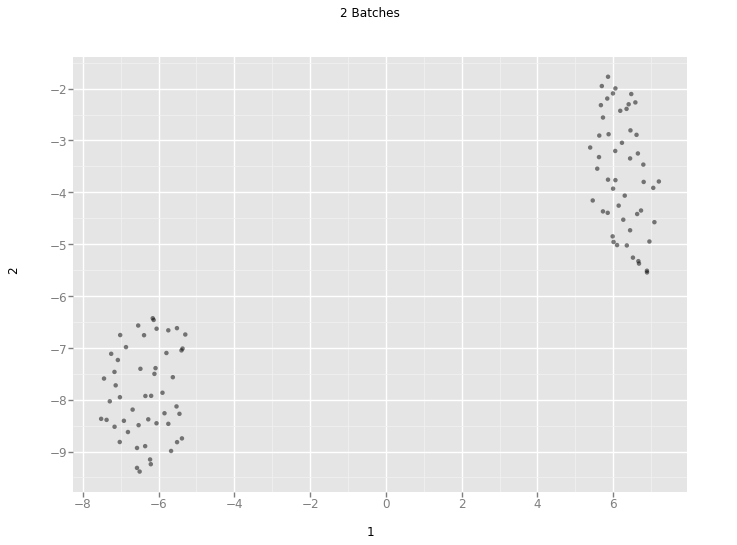

<ggplot: (8774295665223)>


/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 3 connected components using meta-embedding (experimental)
  n_components


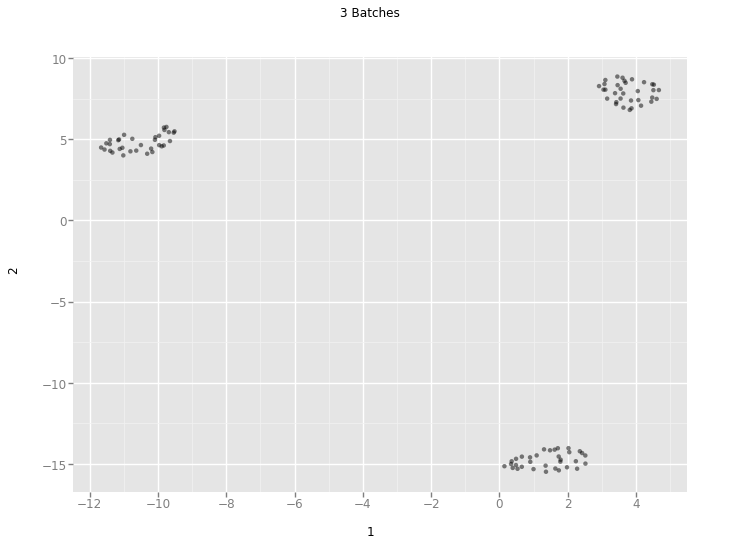

<ggplot: (8774295440704)>


/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 4 connected components using meta-embedding (experimental)
  n_components


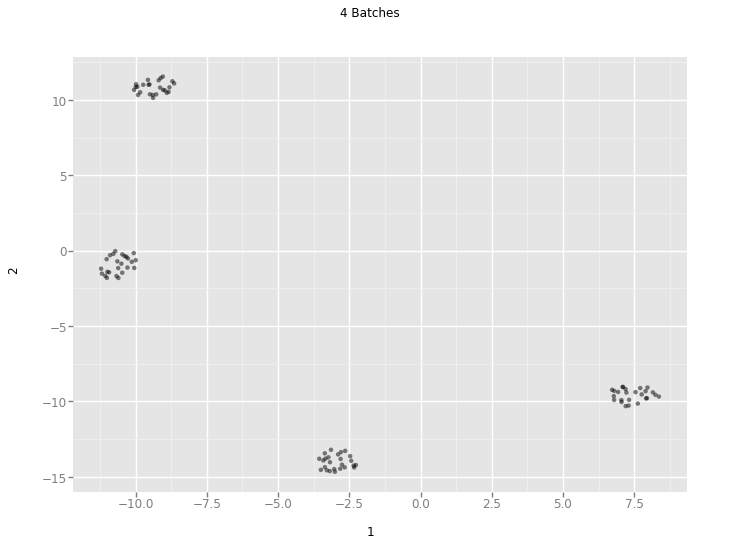

<ggplot: (8774297390070)>


/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 5 connected components using meta-embedding (experimental)
  n_components
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


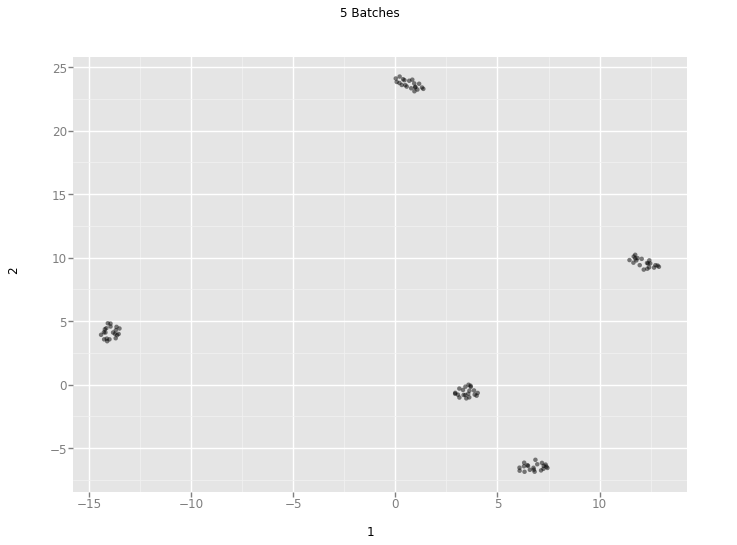

<ggplot: (-9223363262559181340)>


/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 6 connected components using meta-embedding (experimental)
  n_components
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


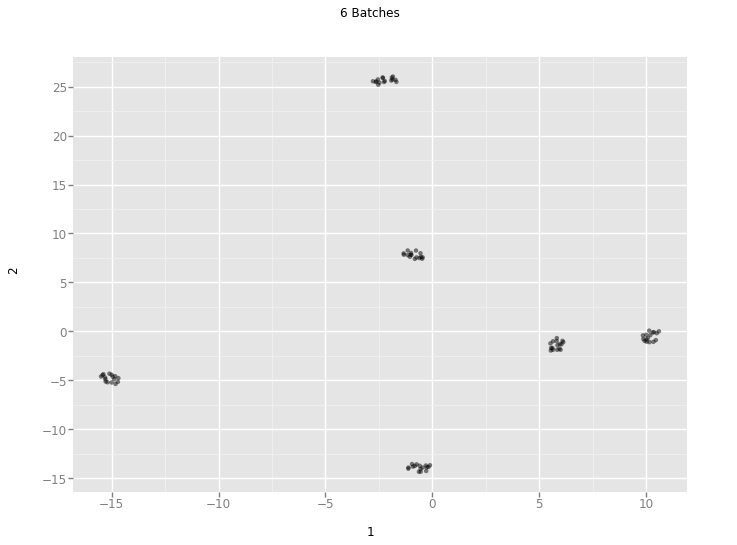

<ggplot: (8774340973839)>


/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 7 connected components using meta-embedding (experimental)
  n_components
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


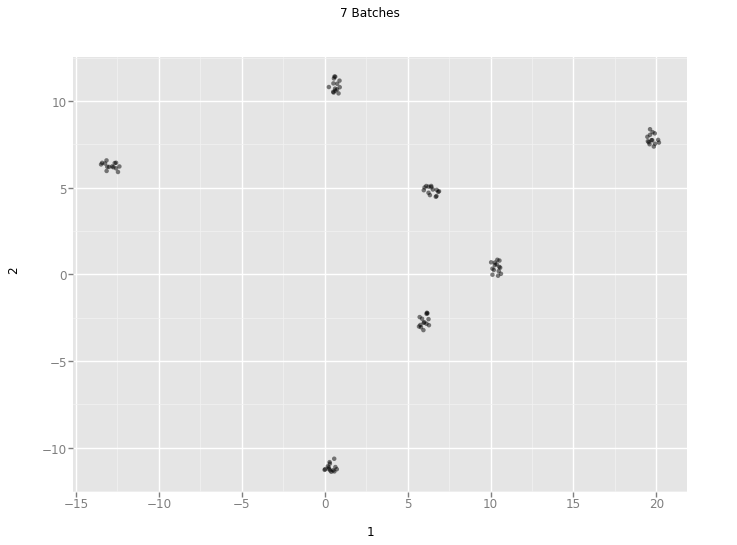

<ggplot: (8774297587169)>


/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 8 connected components using meta-embedding (experimental)
  n_components
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


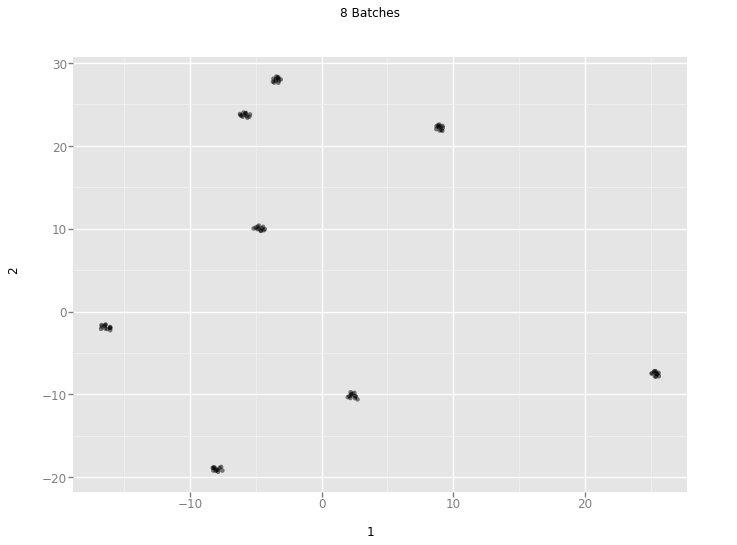

<ggplot: (-9223363262559096092)>


/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 9 connected components using meta-embedding (experimental)
  n_components
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


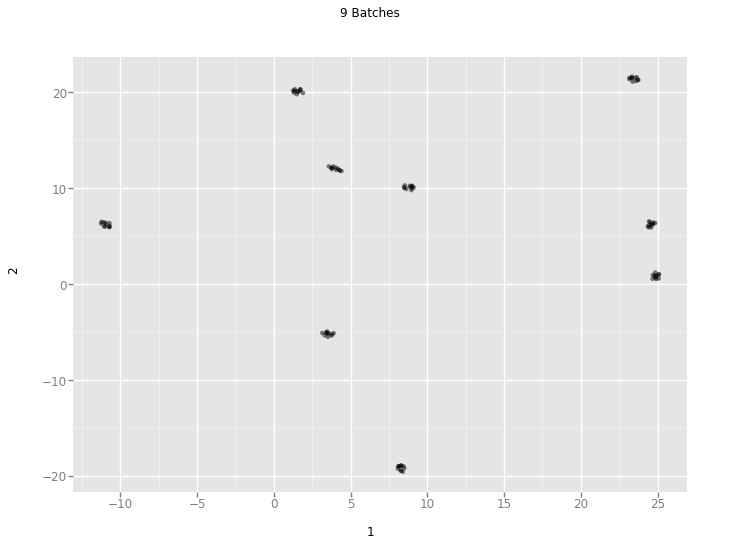

<ggplot: (-9223363262513665848)>


/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 8 connected components using meta-embedding (experimental)
  n_components


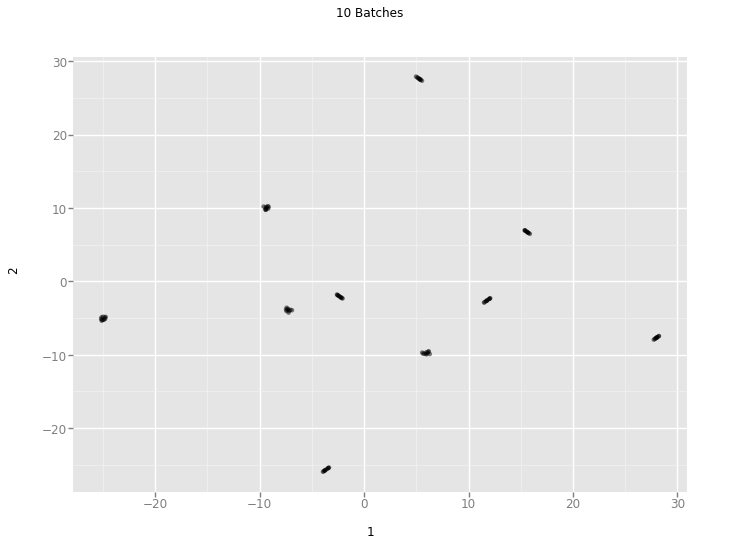

<ggplot: (-9223363262557171631)>


/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 7 connected components using meta-embedding (experimental)
  n_components


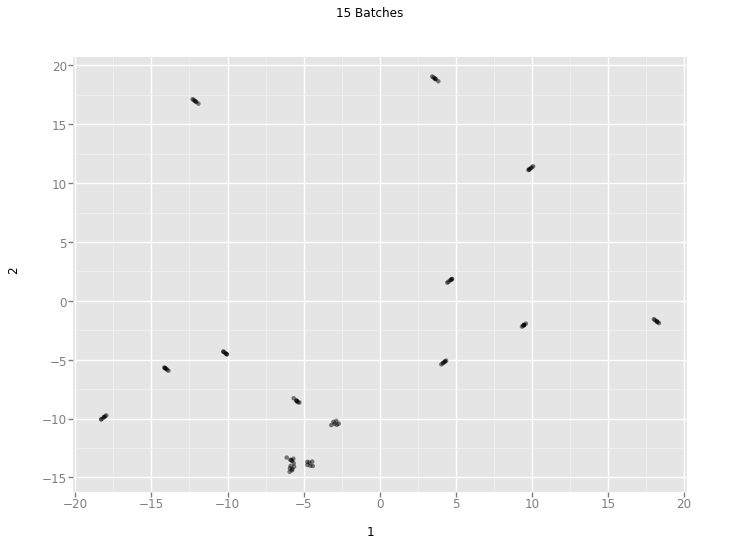

<ggplot: (-9223363262557110654)>


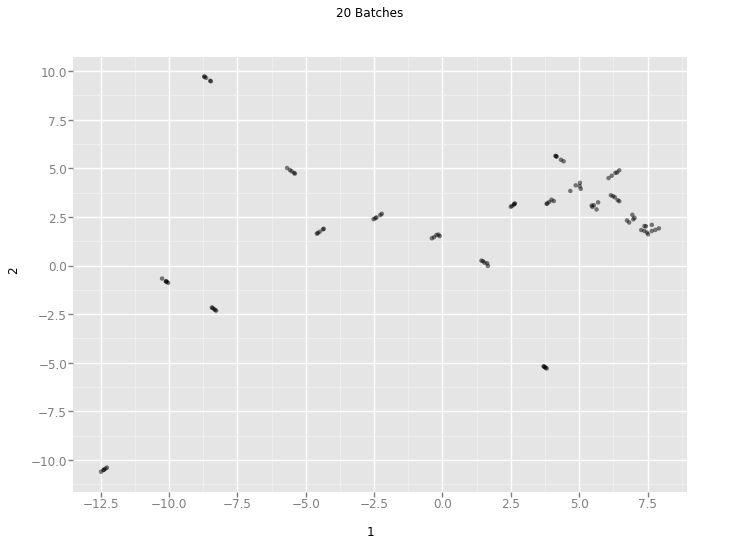

<ggplot: (-9223363262559367094)>


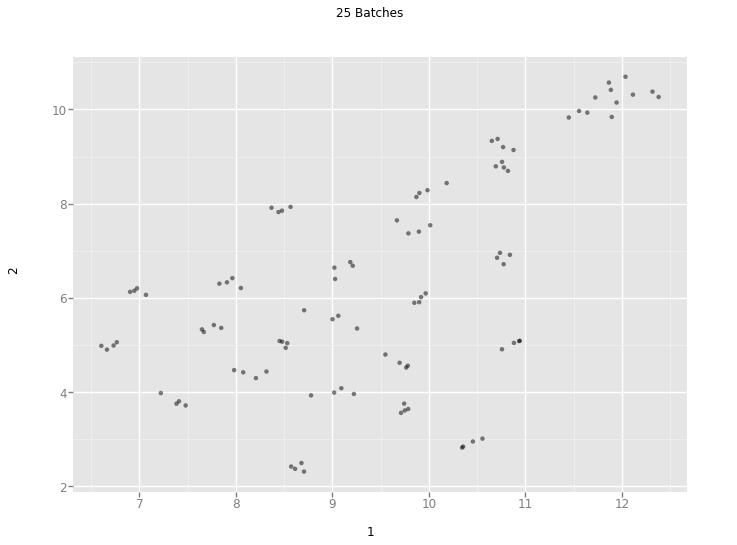

<ggplot: (-9223363262513923987)>


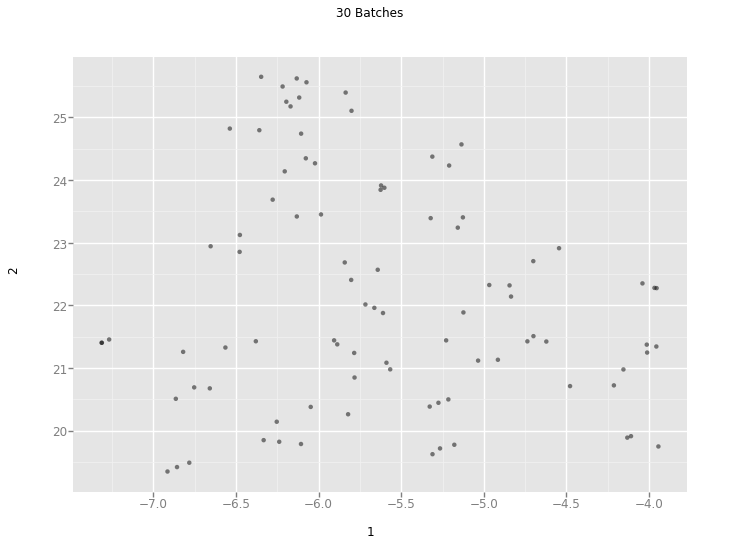

<ggplot: (8774295635264)>


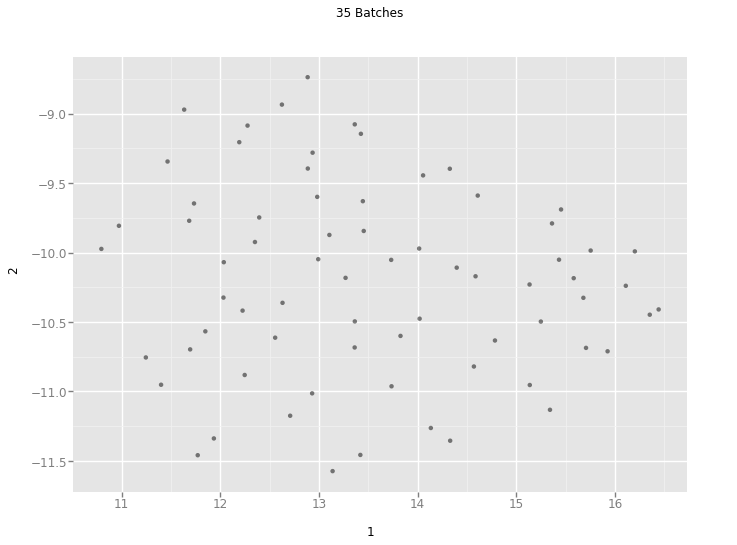

<ggplot: (-9223363262559425690)>


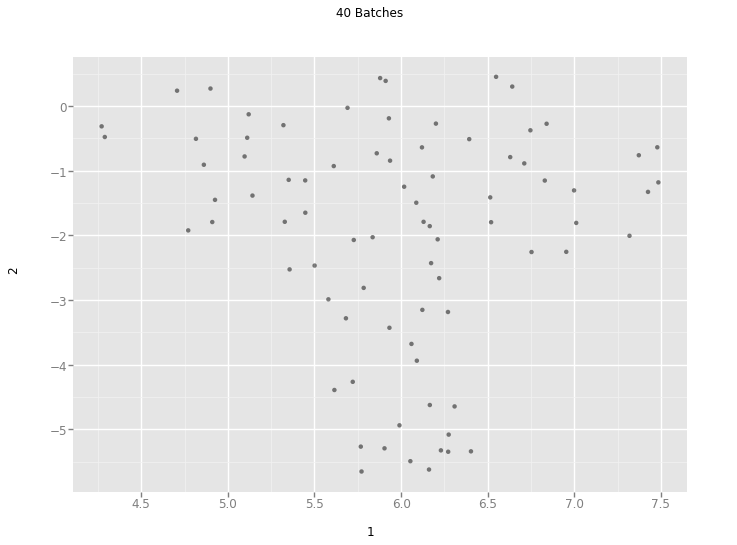

<ggplot: (-9223363262559459433)>


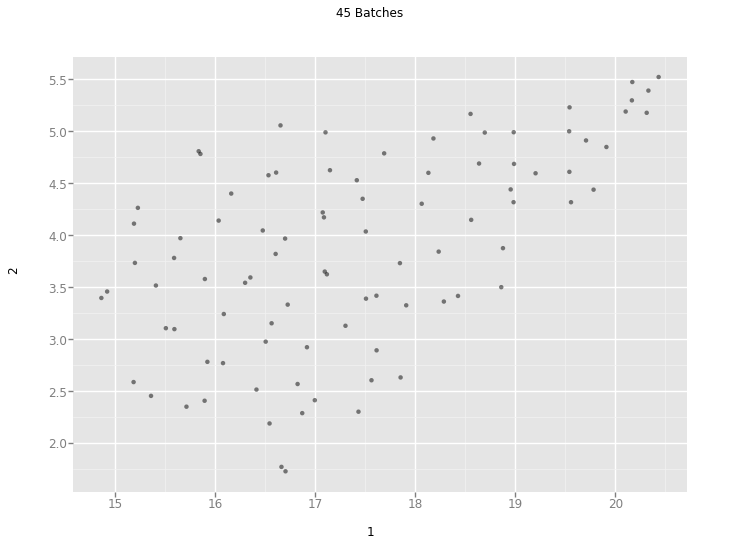

<ggplot: (-9223363262559321312)>


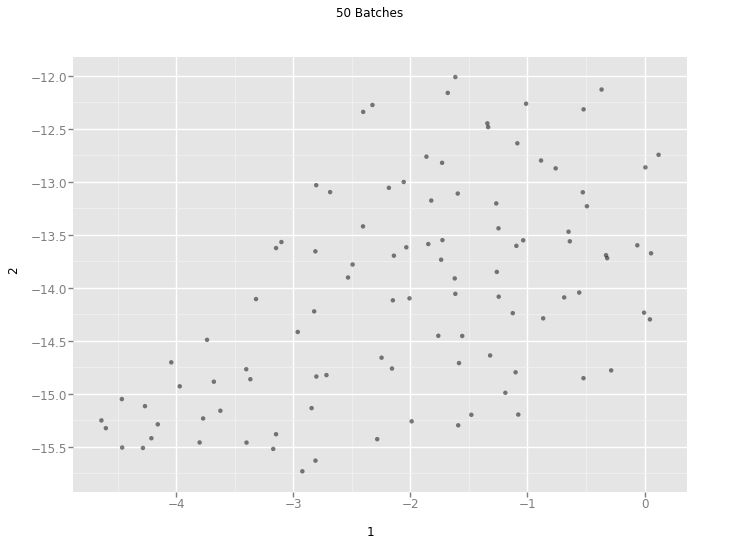

<ggplot: (-9223363262513676428)>


In [7]:
# Plot generated data 

for i in num_batches:
    batch_data_file = os.path.join(
        os.path.dirname(os.getcwd()),
        "data",
        "batch_simulated",
        analysis_name,
        "Batch_"+str(i)+".txt")
    
    batch_data = pd.read_table(
        batch_data_file,
        header=0,
        sep='\t',
        index_col=0)
    
    # UMAP embedding of decoded batch data
    batch_data_UMAPencoded = umap.UMAP().fit_transform(batch_data)
    batch_data_UMAPencoded_df = pd.DataFrame(data=batch_data_UMAPencoded,
                                             index=batch_data.index,
                                             columns=['1','2'])
    
        
    g = ggplot(aes(x='1',y='2'), data=batch_data_UMAPencoded_df) + \
                geom_point(alpha=0.5) + \
                scale_color_brewer(type='qual', palette='Set2') + \
                ggtitle("{} Batches".format(i))
    
    print(g)

## Plot batch data using PCA

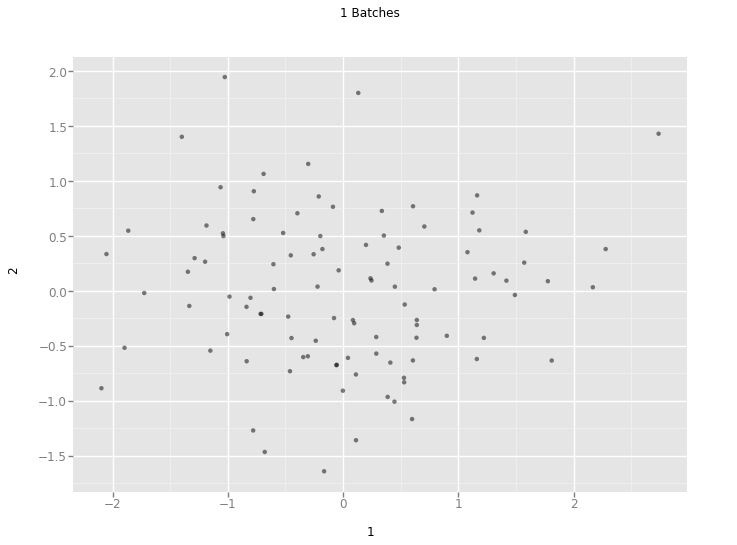

<ggplot: (8774297429361)>


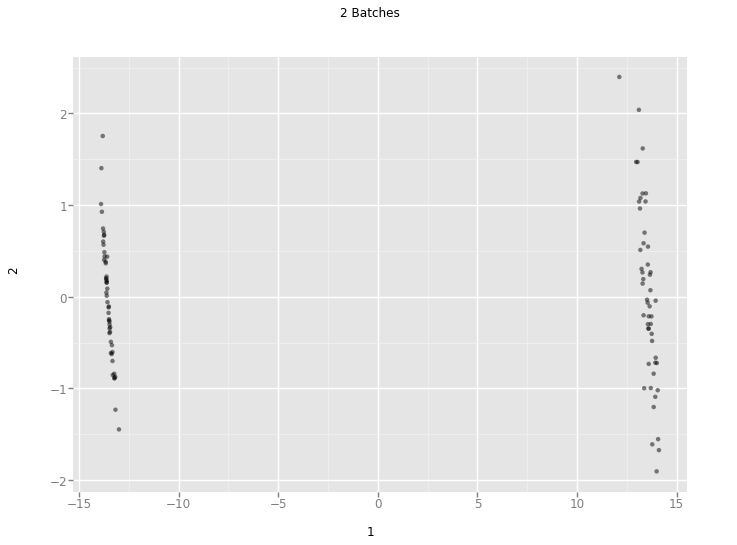

<ggplot: (8774297414990)>


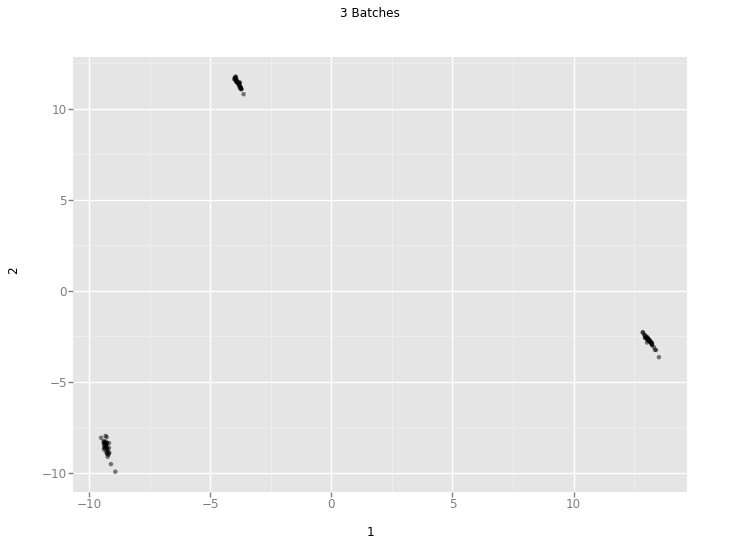

<ggplot: (8774297663741)>


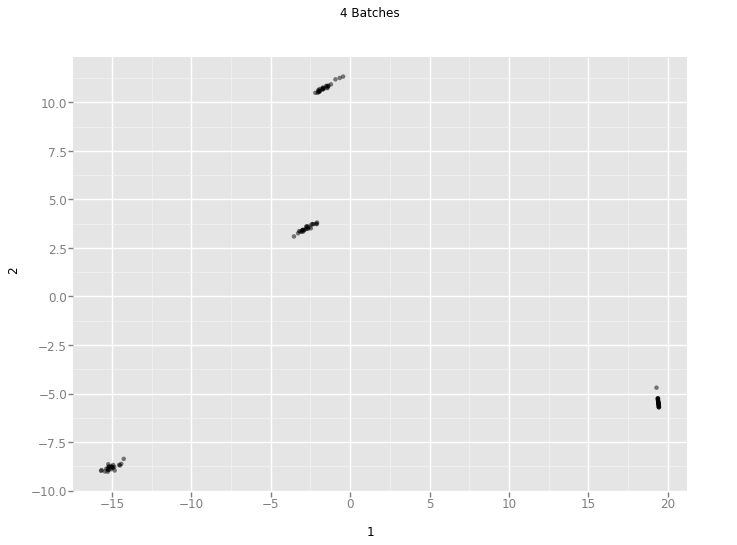

<ggplot: (-9223363262559101710)>


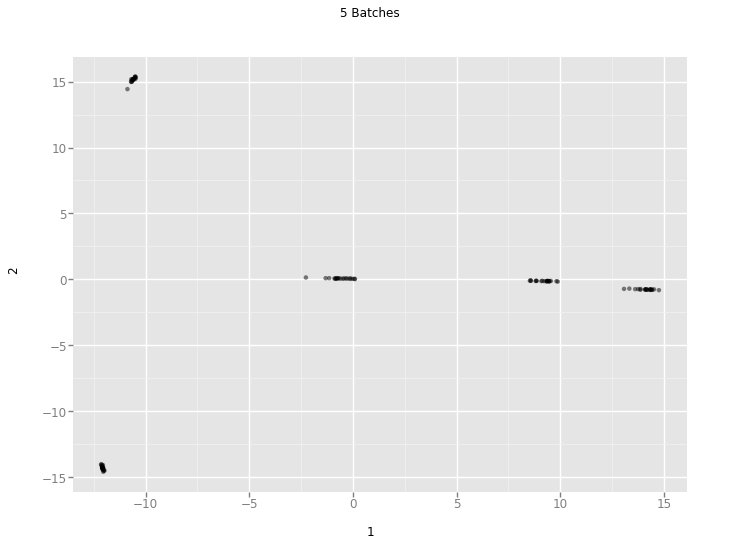

<ggplot: (-9223363262557086222)>


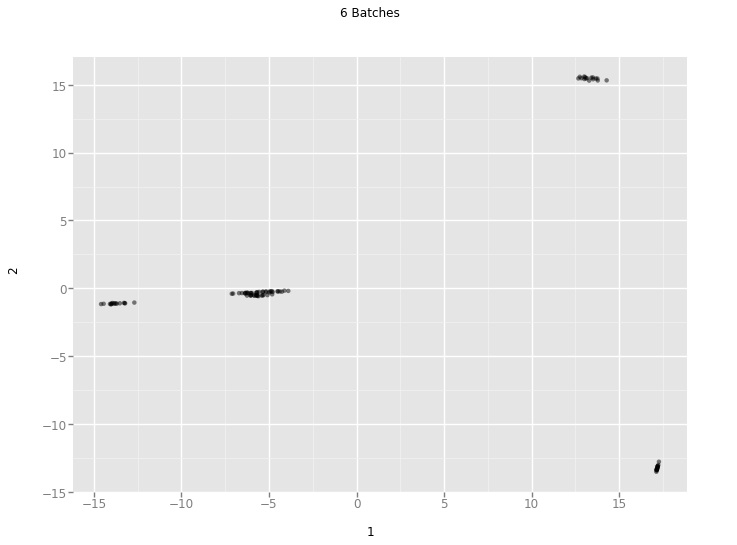

<ggplot: (-9223363262559086960)>


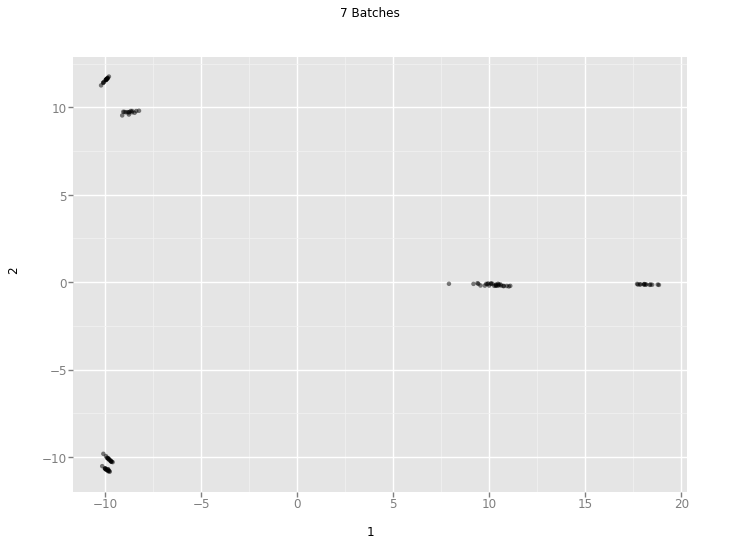

<ggplot: (-9223363262559371141)>


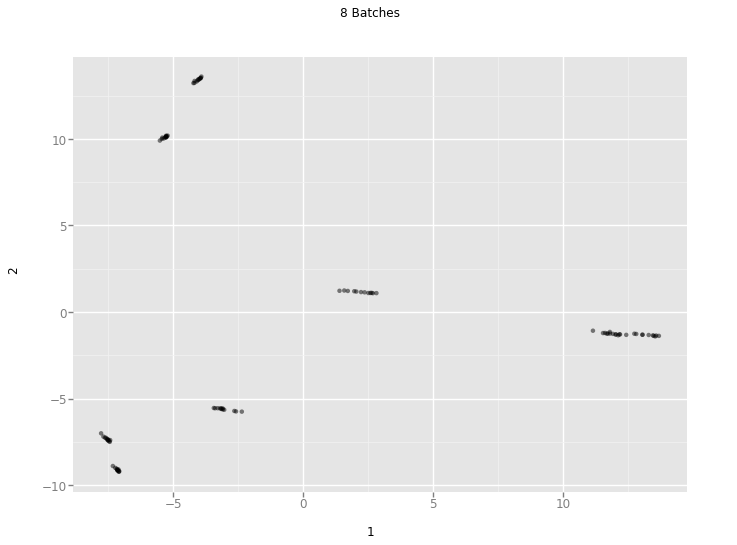

<ggplot: (-9223363262513703848)>


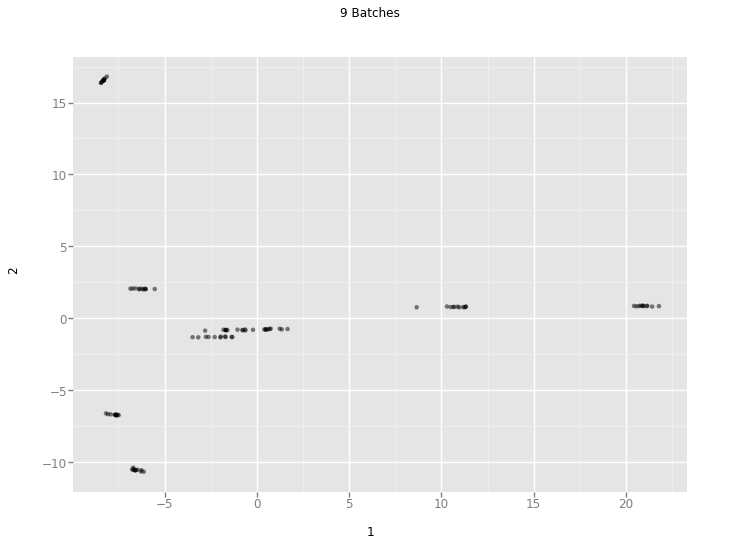

<ggplot: (-9223363262559409106)>


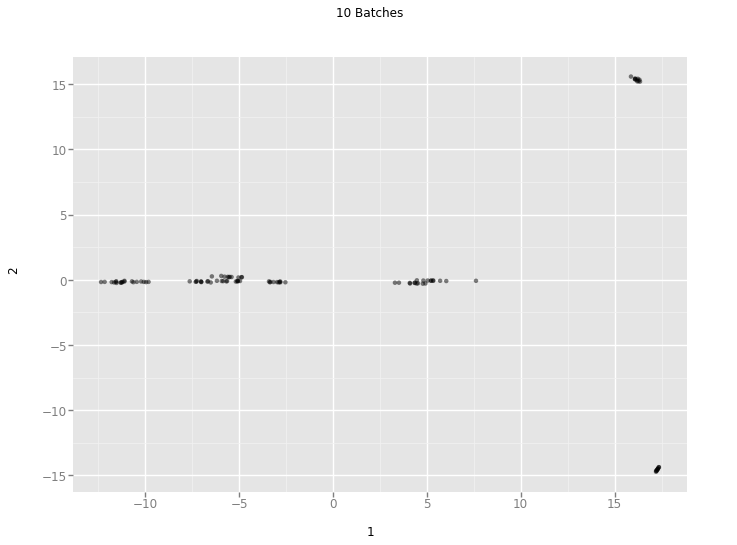

<ggplot: (-9223363262559136652)>


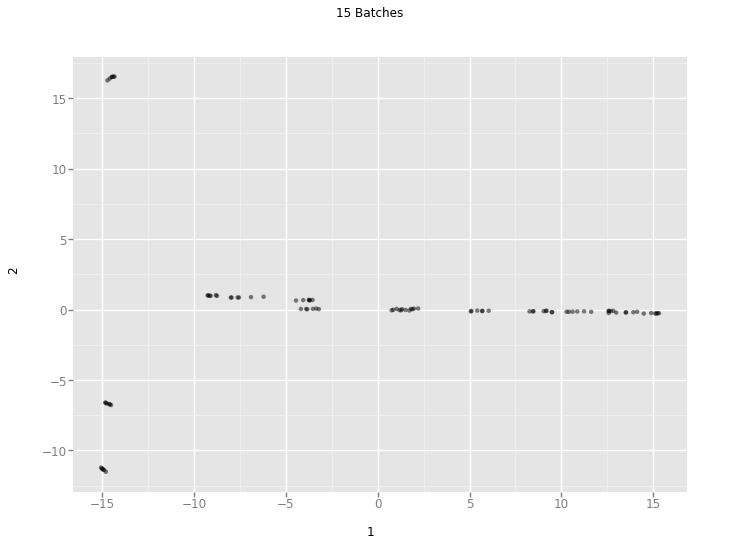

<ggplot: (8774297671267)>


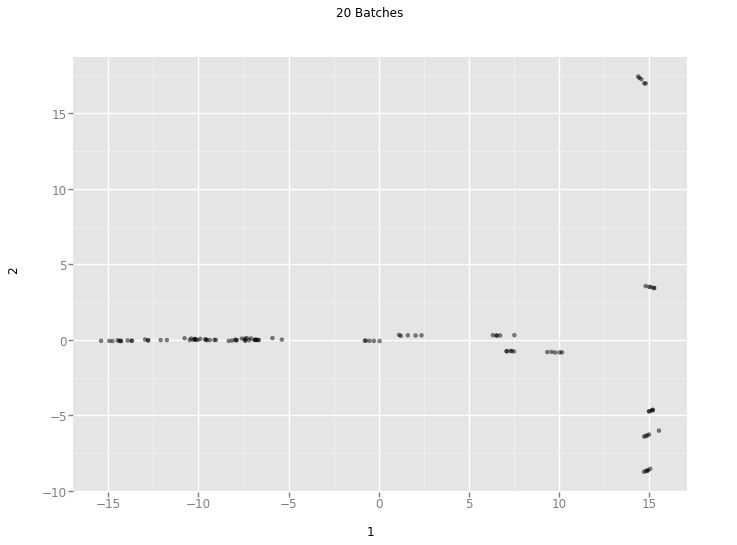

<ggplot: (8774295471094)>


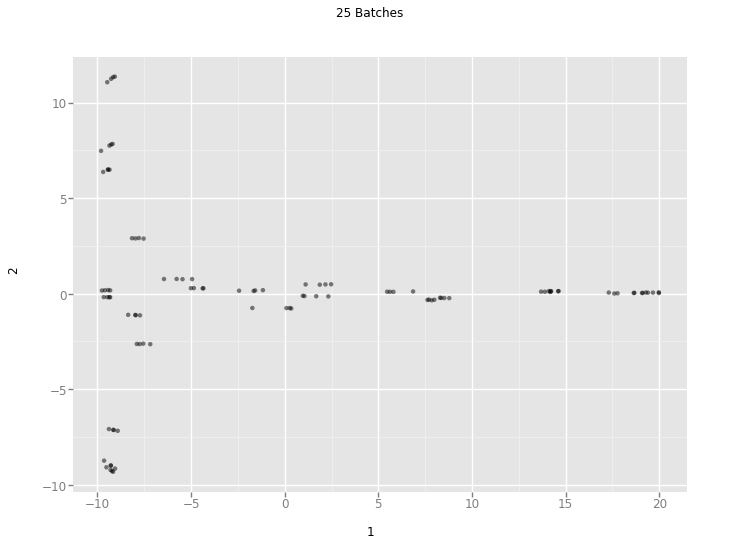

<ggplot: (8774297426310)>


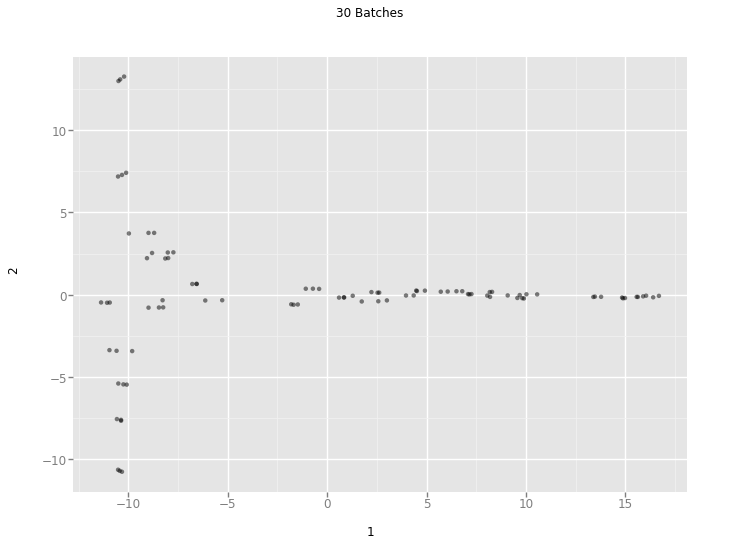

<ggplot: (-9223363262513770247)>


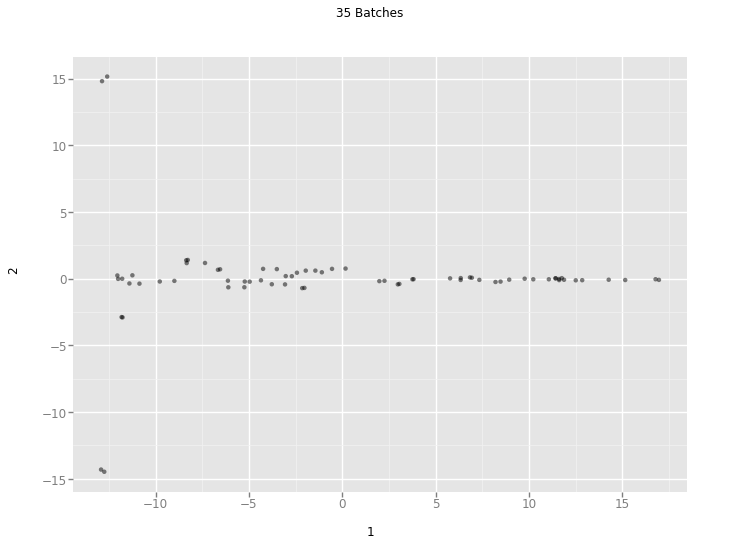

<ggplot: (8774297574113)>


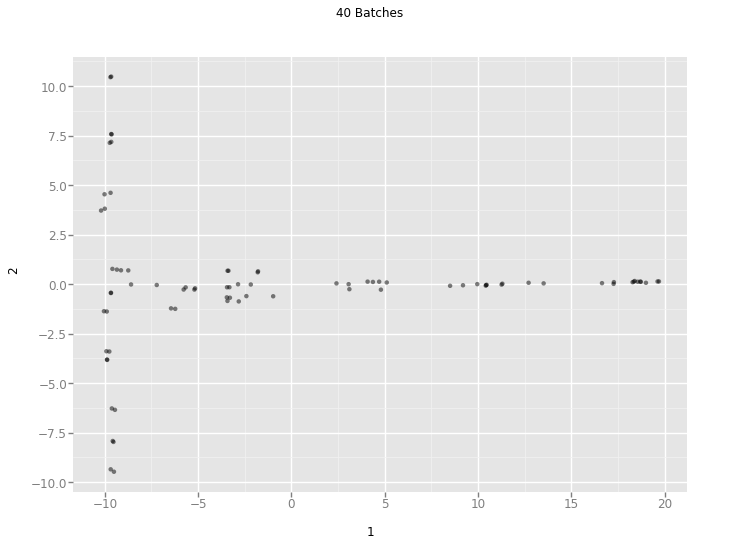

<ggplot: (-9223363262559487309)>


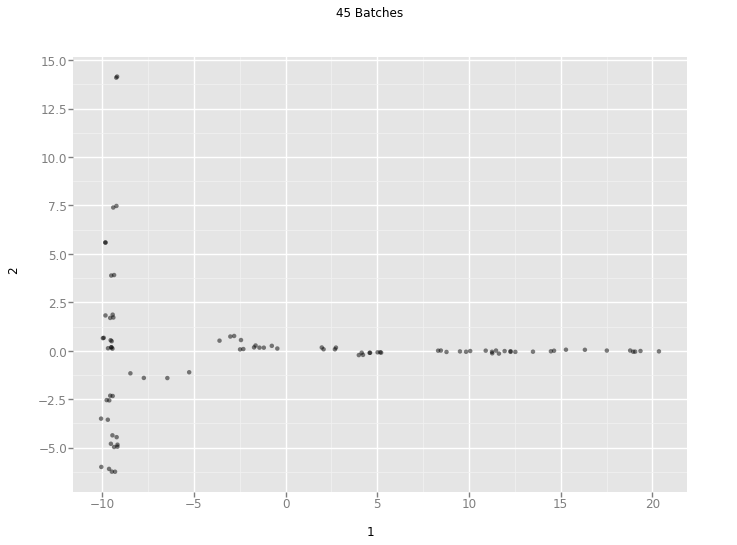

<ggplot: (-9223363262559085273)>


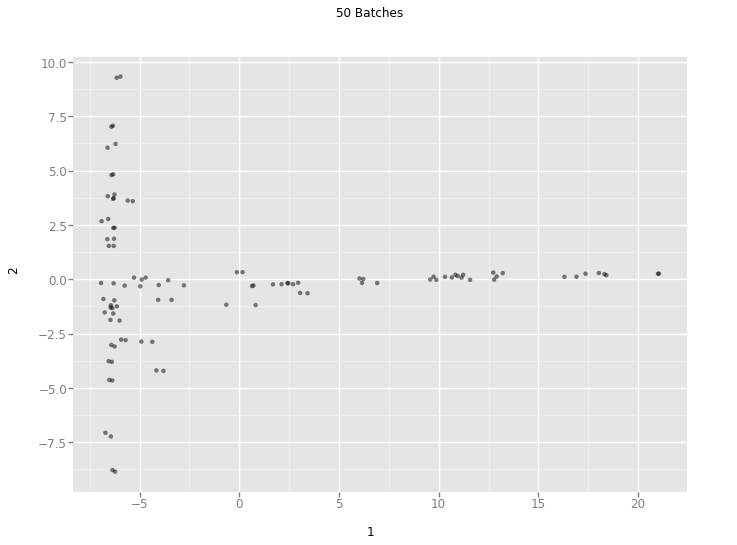

<ggplot: (-9223363262557304930)>


In [8]:
# Plot generated data 

for i in num_batches:
    batch_data_file = os.path.join(
        os.path.dirname(os.getcwd()),
        "data",
        "batch_simulated",
        analysis_name,
        "Batch_"+str(i)+".txt")
    
    batch_data = pd.read_table(
        batch_data_file,
        header=0,
        sep='\t',
        index_col=0)

    # PCA projection
    num_PCs = 2
    pca = PCA(n_components=num_PCs)

    # Use trained model to encode expression data into SAME latent space
    batch_data_PCAencoded = pca.fit_transform(batch_data)
    
    
    batch_data_PCAencoded_df = pd.DataFrame(batch_data_PCAencoded,
                                         index=batch_data.index,
                                         columns=['1', '2'])
    
    g = ggplot(aes(x='1',y='2'), data=batch_data_PCAencoded_df)  + \
                geom_point(alpha=0.5) + \
                scale_color_brewer(type='qual', palette='Set2') + \
                ggtitle("{} Batches".format(i))
    print(g)